## データ読み込み

In [1]:
import sqlite3
conn = sqlite3.connect('gbiz.sqlite3')

In [2]:
import pandas as pd

subsidy_df = pd.read_sql_query("SELECT * FROM subsidies", conn)
company_df = pd.read_sql_query("SELECT * FROM companies", conn)


In [3]:
import humanize

subsidy_df["円"] = subsidy_df["amount"].apply(humanize.intword)

subsidy_df.columns = subsidy_df.columns.astype(str)  # カラム名を文字列として明示
company_df.columns = company_df.columns.astype(str)  # カラム名を文字列として明示


## データ分析

In [4]:
company_counts_df = subsidy_df.groupby('corporate_number').agg({
    'id': 'count',
    'amount': lambda x: pd.to_numeric(x.fillna(0), errors='coerce').sum(),
    'government_departments': lambda x: x.nunique()
}).rename(columns={'id': 'subsidy_count', 'amount': 'total_amount'}).sort_values('subsidy_count', ascending=False)


/var/folders/pv/3g2620ld3rs7s8h3vfphb4w80000gn/T/ipykernel_37247/4172010492.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  'amount': lambda x: pd.to_numeric(x.fillna(0), errors='coerce').sum(),


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

def subsidy_trend_analysis(df, variable, window_size, polyorder, skip_initial=10, return_groups=True):
    # データを取得
    subsidy_counts = df[variable].values
    x = np.arange(len(subsidy_counts))
    
    # サブプロットを作成（2行1列）
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # 全データを元のグラフに表示
    ax1.plot(x, subsidy_counts, 'o-', color='skyblue', alpha=0.5, label='Original Data')
    
    # Savitzky-Golay フィルターで平滑化（全データ）
    smoothed = savgol_filter(subsidy_counts, window_size, polyorder)
    ax1.plot(x, smoothed, '-', color='blue', linewidth=2, label='Smoothed Curve')
    
    # 初期の急激な変化を除外した範囲を強調表示
    ax1.axvspan(skip_initial, len(x), alpha=0.2, color='green', label='Analysis Range')
    
    ax1.set_title('Distribution of Subsidy Count (Linear)', fontsize=16)
    ax1.set_xlabel('Company Index', fontsize=12)
    ax1.set_ylabel('Subsidy Count', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 一次微分グラフ（変化率）- 制限範囲のみ
    # 制限範囲のデータと微分を計算
    x_limited = x[skip_initial:]
    smoothed_limited = smoothed[skip_initial:]
    derivatives = np.gradient(smoothed_limited)
    
    ax2.plot(x_limited, derivatives, '-', color='red', linewidth=2)
    
    # 微分の閾値を設定して、重要な変化点を検出
    threshold = np.std(derivatives) * 0.5
    significant_changes = np.where(np.abs(derivatives) > threshold)[0]
    
    # 微分が大きく変化する点をマーク
    ax2.scatter(x_limited[significant_changes], derivatives[significant_changes], 
               color='darkred', s=50, label='Significant Change Points')
    
    # 上位のいくつかの変化点を特定してラベル付け
    top_changes = sorted(significant_changes, key=lambda i: abs(derivatives[i]), reverse=True)[:5]
    
    # 元のインデックスに変換
    original_indices = [i + skip_initial for i in top_changes]
    
    for i, idx in enumerate(top_changes):
        original_idx = original_indices[i]
        ax2.annotate(f'idx={original_idx}, val={subsidy_counts[original_idx]}', 
                    xy=(x_limited[idx], derivatives[idx]),
                    xytext=(x_limited[idx]+5, derivatives[idx]),
                    arrowprops=dict(arrowstyle='->'))
    
    ax2.set_title('Change Rate (First Derivative) - Excluding Initial Range', fontsize=16)
    ax2.set_xlabel('Company Index', fontsize=12)
    ax2.set_ylabel('Change Rate', fontsize=12)
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # グラフレイアウトの調整
    plt.tight_layout()
    plt.show()
    
    # 重要な変化点のインデックスとその値を表示
    print("Important change points (excluding initial range):")
    for i, idx in enumerate(top_changes):
        original_idx = original_indices[i]
        print(f"Index: {original_idx}, Subsidy Count: {subsidy_counts[original_idx]}, Change Rate: {derivatives[idx]:.4f}")
    
    # グループ分割を行う場合
    if return_groups:
        # 最も重要な変化点を特定（絶対値が最も大きい微分点を選択）
        critical_idx = sorted(top_changes, key=lambda i: abs(derivatives[i]), reverse=True)[0]
        original_critical_idx = critical_idx + skip_initial
        threshold_value = subsidy_counts[original_critical_idx]
        
        print(f"\nCritical threshold value: {threshold_value}")
        
        # 高頻度グループと低頻度グループに分割
        high_frequency_group_df = df[df[variable] >= threshold_value].copy()
        low_frequency_group_df = df[df[variable] < threshold_value].copy()
        
        print(f"High frequency group size: {len(high_frequency_group_df)}")
        print(f"Low frequency group size: {len(low_frequency_group_df)}")
        
        return high_frequency_group_df, low_frequency_group_df, threshold_value
    
    return None

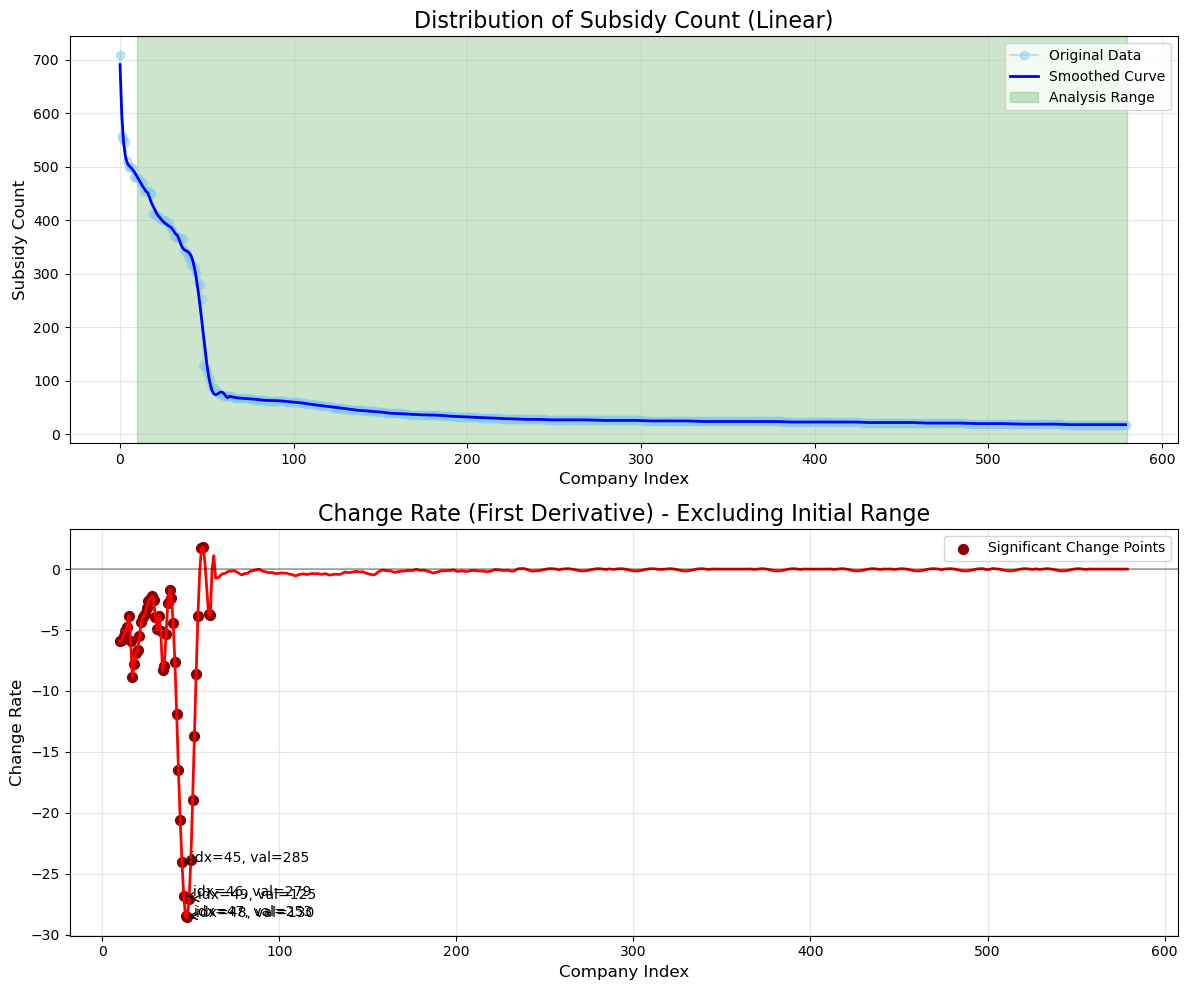

Important change points (excluding initial range):
Index: 48, Subsidy Count: 130, Change Rate: -28.5702
Index: 47, Subsidy Count: 253, Change Rate: -28.4847
Index: 49, Subsidy Count: 125, Change Rate: -27.1016
Index: 46, Subsidy Count: 279, Change Rate: -26.8472
Index: 45, Subsidy Count: 285, Change Rate: -24.0711

Critical threshold value: 130
High frequency group size: 49
Low frequency group size: 531


In [6]:
high_frequency_group_df, low_frequency_group_df, threshold_value = subsidy_trend_analysis(
  df=company_counts_df.head(580), 
  variable='subsidy_count',
  window_size=31, polyorder=7,
  skip_initial=10
)


In [8]:
low_frequency_group_df.shape[0]

531

In [9]:
df_outer = pd.merge(low_frequency_group_df, company_df, on='corporate_number', how='left')


In [ ]:
df_outer.head()

In [ ]:
df_outer[["name","subsidy_count","total_amount"]].head(5)